In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np      

In [2]:
DataLeft = pd.read_csv(r'C:\Users\Nathan\Desktop\Guttenberg Gait Database\GRF_F_V_PRO_left.csv')
DataRight = pd.read_csv(r'C:\Users\Nathan\Desktop\Guttenberg Gait Database\GRF_F_V_PRO_right.csv')

In [3]:
def TransformDataFrame(DataFrame):
    DataFrame = DataFrame.drop(['DATASET_ID', 'SUBJECT_ID', 'SESSION_ID', 'TRIAL_ID'], axis = 1)
    DataFrame = DataFrame.T
    DataFrame = DataFrame * 100
    return DataFrame

def SelectSuject(ID, DataLeft, DataRight):
    DataSubjectLeft = DataLeft[DataLeft['SUBJECT_ID'] == ID]
    DataSubjectRight = DataRight[DataRight['SUBJECT_ID'] == ID]
    DataSubjectLeft = TransformDataFrame(DataSubjectLeft)
    DataSubjectRight = TransformDataFrame(DataSubjectRight)
    return DataSubjectLeft, DataSubjectRight

def TabGrfTotal(DataSubjectLeft, DataSubjectRight, decalage):
    GrfRight = [-999]
    GrfLeft = [-999]

    SwingLeft = [0] * (100 - (2 *decalage))
    SwingRight = [0] * (100 - (2 *decalage))
    
    for col in zip(DataSubjectLeft.columns, DataSubjectRight.columns):
        GrfLeft = np.concatenate((GrfLeft, DataSubjectLeft[col[0]], SwingLeft), axis = 0)
        GrfRight = np.concatenate((GrfRight, DataSubjectRight[col[1]], SwingRight), axis = 0)

    GrfLeft = GrfLeft[1:]
    GrfRight = GrfRight[1:]
    GrfLeft = GrfLeft[(100 - decalage):]
    GrfRight = GrfRight[ : (len(GrfRight)-(100 - decalage))]
    
    return GrfLeft, GrfRight

def MakeDataFrameGlobalGrf(GrfLeft, GrfRight):
    DataFrameGlobalGrf = pd.DataFrame()
    DataFrameGlobalGrf["LeftGrf"] = GrfLeft
    DataFrameGlobalGrf["RightGrf"] = GrfRight
    DataFrameGlobalGrf["SumGrf"] = DataFrameGlobalGrf.apply(np.sum, axis = 1)
    return DataFrameGlobalGrf


In [4]:
DataSubjectLeft, DataSubjectRight = SelectSuject(1, DataLeft, DataRight)
GrfLeft, GrfRight = TabGrfTotal(DataSubjectLeft, DataSubjectRight, decalage = 15)
DataFrameGlobalGrf = MakeDataFrameGlobalGrf(GrfLeft, GrfRight)

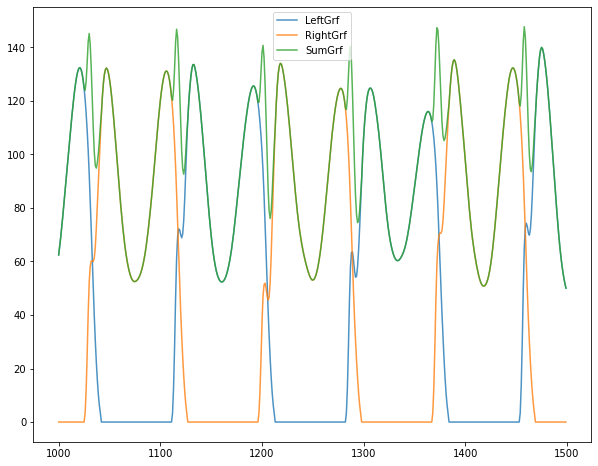

In [5]:
plt.figure(figsize=(10,8))
for col in DataFrameGlobalGrf.columns:
    plt.plot(DataFrameGlobalGrf[col][1000: 1500], alpha = 0.8 , label = col)
    plt.legend()

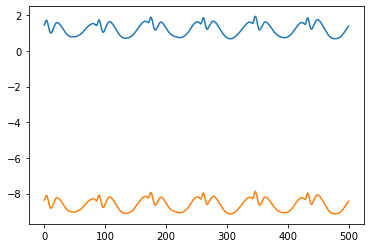

In [6]:
masse = 80
g = 9.81
DataFrameGlobalGrf["AccGrfNoCor"] = DataFrameGlobalGrf["SumGrf"] / masse
DataFrameGlobalGrf["AccGrf"] = (DataFrameGlobalGrf["SumGrf"] - masse * g) / masse
plt.plot(DataFrameGlobalGrf["AccGrfNoCor"][0:500])
plt.plot(DataFrameGlobalGrf["AccGrf"][0:500])

c:\Users\Nathan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


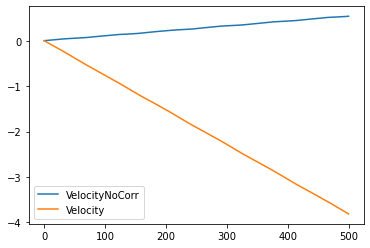

In [7]:
from scipy.integrate import cumtrapz
Frequency = 1125
DataFrameGlobalGrf["VelocityNoCorr"] = cumtrapz(DataFrameGlobalGrf["AccGrfNoCor"], dx=1/Frequency, initial= 0.0)
DataFrameGlobalGrf["Velocity"] = cumtrapz(DataFrameGlobalGrf["AccGrf"], dx=1/Frequency, initial= 0.0)

plt.plot(DataFrameGlobalGrf["VelocityNoCorr"][0:500], label=DataFrameGlobalGrf["VelocityNoCorr"].name)
plt.plot(DataFrameGlobalGrf["Velocity"][0:500], label=DataFrameGlobalGrf["Velocity"].name)
plt.legend()

Test couper dataframe en x parties pour voir l'évolution

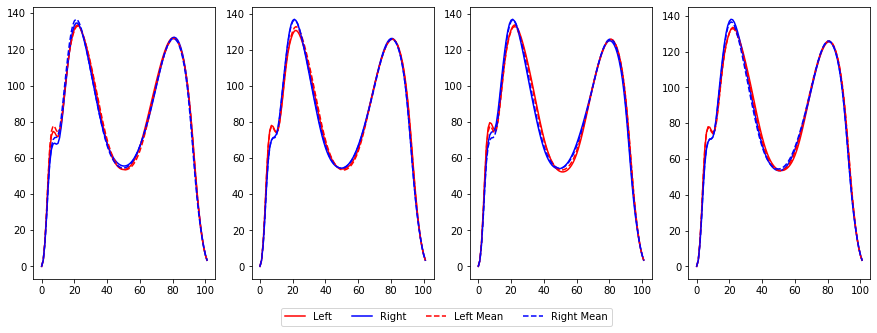

In [8]:
from CutDataGrf import CutDataGrf, MeanCutDataGrf, PlotCutDataGrf
GrfDataframeCut = CutDataGrf(GrfLeft = pd.array(DataFrameGlobalGrf["LeftGrf"]), 
                             GrfRight = pd.array(DataFrameGlobalGrf["RightGrf"]), 
                             n_cut=4)
MeanGrfDataframeCut = MeanCutDataGrf(GrfDataframeCut)
PlotCutDataGrf(MeanGrfDataframeCut)

Test en prenant les valeurs d'un sujet pour la droite et d'un autre pour la gauche

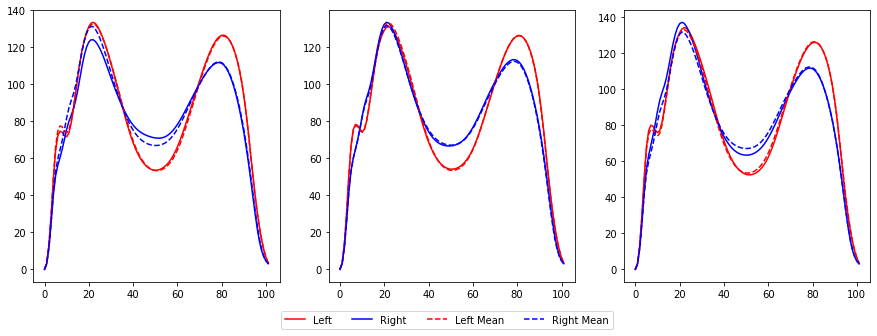

In [14]:
DataSubjectLeft = DataLeft[DataLeft['SUBJECT_ID'] == 1]
DataSubjectRight = DataRight[DataRight['SUBJECT_ID'] == 12]
DataSubjectLeft = TransformDataFrame(DataSubjectLeft)
DataSubjectRight = TransformDataFrame(DataSubjectRight)
GrfLeft, GrfRight = TabGrfTotal(DataSubjectLeft, DataSubjectRight, decalage = 15)
DataFrameGlobalGrf = MakeDataFrameGlobalGrf(GrfLeft, GrfRight)

from CutDataGrf import CutDataGrf, MeanCutDataGrf, PlotCutDataGrf
GrfDataframeCut = CutDataGrf(pd.array(DataFrameGlobalGrf["LeftGrf"]), 
                             pd.array(DataFrameGlobalGrf["RightGrf"]), 
                             n_cut=3)
MeanGrfDataframeCut = MeanCutDataGrf(GrfDataframeCut)
PlotCutDataGrf(MeanGrfDataframeCut)

Rajouter en dessous les courbes de DFS 1/2/3 sur une seule est même courbe

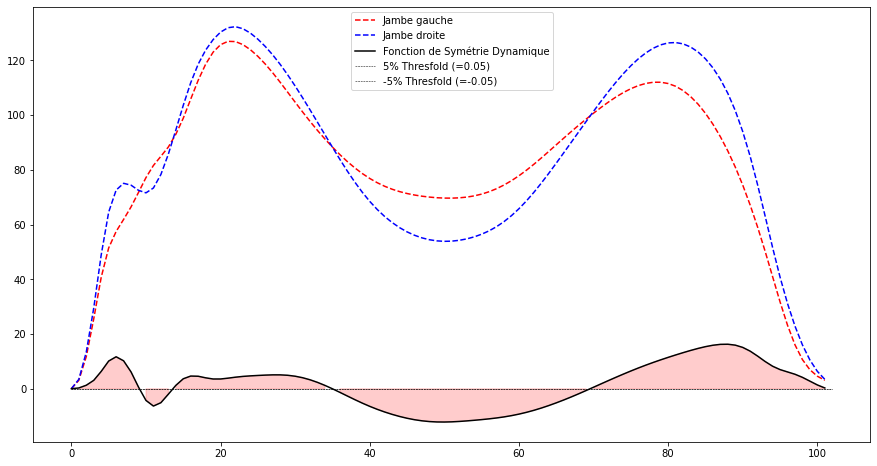

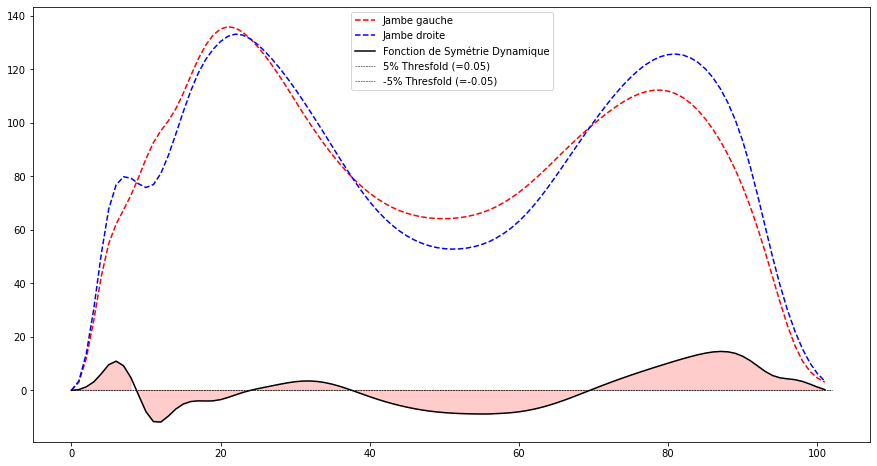

In [10]:
from DynamicSymetryFunctionProcedure import PlotDynamicSymetryFunctionRealtime

colNames = MeanGrfDataframeCut.columns
DataFrameDSF = pd.DataFrame()

for cut in range(0, MeanGrfDataframeCut.columns.shape[0], 2):
    DataFrameVerticalGrf = PlotDynamicSymetryFunctionRealtime(VerticalGrfRight = MeanGrfDataframeCut[colNames[cut]],
                                       VerticalGrfLeft = MeanGrfDataframeCut[colNames[cut + 1]], GetData = True)
    DataFrameDSF[f"DFS{(cut//2)}"] = DataFrameVerticalGrf['FunctionDynamicAssym']


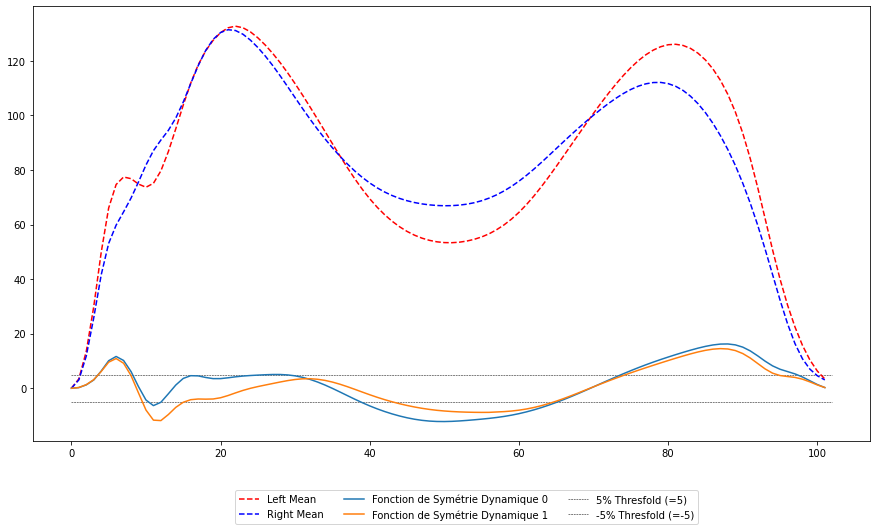

In [11]:
MeanGrfDataframeCutLeft = pd.DataFrame()
MeanGrfDataframeCutRight = pd.DataFrame()
for colIndex in zip(range(0, MeanGrfDataframeCut.shape[1], 2),
                        range(1,MeanGrfDataframeCut.shape[1] + 1, 2)):
    MeanGrfDataframeCutLeft[colIndex] = MeanGrfDataframeCut[MeanGrfDataframeCut.columns[colIndex[0]]]
    MeanGrfDataframeCutRight[colIndex] = MeanGrfDataframeCut[MeanGrfDataframeCut.columns[colIndex[1]]]
MeanGrfDataframeCutLeft["MeanOfLeft"] = MeanGrfDataframeCutLeft.mean(axis = 1)
MeanGrfDataframeCutRight["MeanOfRight"] = MeanGrfDataframeCutRight.mean(axis = 1)

Thresfold = 5

plt.figure(figsize=(15,8))
plt.plot(MeanGrfDataframeCutLeft["MeanOfLeft"], c = "red", ls="--", label="Left Mean")
plt.plot(MeanGrfDataframeCutRight["MeanOfRight"], c = "blue", ls="--", label="Right Mean")
for cut in range(0, DataFrameDSF.shape[1]):
    plt.plot(DataFrameDSF[f'DFS{cut}'], label = f'Fonction de Symétrie Dynamique {cut}')

plt.hlines(y = Thresfold , xmin=0, xmax = DataFrameDSF.shape[0], colors='black',
            lw=0.5, ls='--', label = f'5% Thresfold (={Thresfold})')
plt.hlines(y = -Thresfold, xmin=0, xmax = DataFrameDSF.shape[0], colors='black',
            lw=0.5, ls='--', label = f'-5% Thresfold (={-Thresfold})')
plt.legend(ncol = 3, bbox_to_anchor = (0.8, -0.1) )
plt.show()